- reference : https://leimao.github.io/blog/Exponential-Moving-Average/

### 1.EMA를 사용하지 않는 경우

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# 모델 정의 (간단한 예시)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(10, 1)
    
    def forward(self, x):
        return self.fc(x)

# 인스턴스 생성, 손실 함수, 옵티마이저 설정
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 가상의 학습 데이터
inputs = torch.randn(10, 10)
targets = torch.randn(10, 1)

# 학습 과정
model.train()
for epoch in range(5):  # 에폭 수는 예시입니다.
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.4721662998199463
Epoch 2, Loss: 0.4622732102870941
Epoch 3, Loss: 0.45295700430870056
Epoch 4, Loss: 0.4441681504249573
Epoch 5, Loss: 0.435861736536026


### 2.EMA를 사용하는 경우

In [2]:
# EMA를 위한 가중치 업데이트 함수
def update_ema(model, ema_model, alpha=0.999):
    with torch.no_grad():
        for param, ema_param in zip(model.parameters(), ema_model.parameters()):
            ema_param.data.mul_(alpha).add_(param.data, alpha=1-alpha)

# EMA 모델 생성 (가중치 초기화는 동일하게)
ema_model = SimpleModel()
ema_model.load_state_dict(model.state_dict())

# 학습 과정 (EMA 적용)
model.train()
for epoch in range(5):  # 에폭 수는 예시입니다.
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    # EMA 업데이트
    update_ema(model, ema_model, alpha=0.999)
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.4279981255531311
Epoch 2, Loss: 0.4205411970615387
Epoch 3, Loss: 0.41345858573913574
Epoch 4, Loss: 0.4067210257053375
Epoch 5, Loss: 0.40030211210250854


In [3]:
# EMA 적용 모델의 가중치 확인
for param, ema_param in zip(model.parameters(), ema_model.parameters()):
    print("Original Param:", param.data, "\nEMA Param:", ema_param.data)

Original Param: tensor([[ 0.3063, -0.2195,  0.1186,  0.0491, -0.2596,  0.0572, -0.1204, -0.1712,
          0.2669,  0.0606]]) 
EMA Param: tensor([[ 0.3011, -0.2172,  0.1312,  0.0424, -0.2507,  0.0700, -0.1510, -0.1643,
          0.2612,  0.0743]])
Original Param: tensor([0.2460]) 
EMA Param: tensor([0.2410])


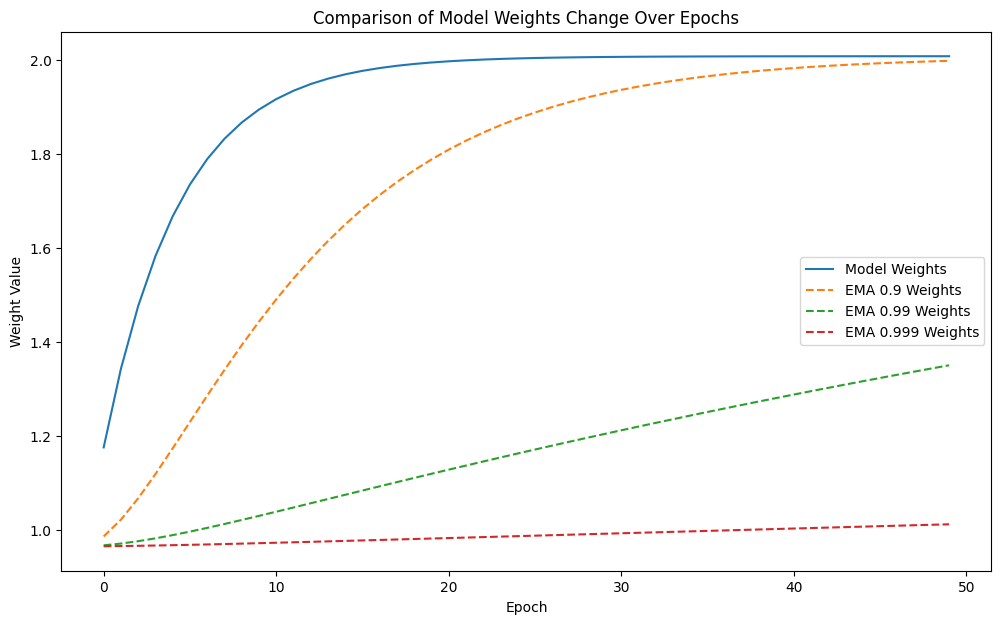

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 모델 정의
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 1차원 입력, 1차원 출력

    def forward(self, x):
        return self.linear(x)

# EMA 업데이트 함수
def update_ema(model, ema_model, alpha=0.999):
    with torch.no_grad():
        for param, ema_param in zip(model.parameters(), ema_model.parameters()):
            ema_param.data = alpha * ema_param.data + (1 - alpha) * param.data

# 데이터 생성
inputs = torch.randn(100, 1)
targets = 2 * inputs + torch.randn(100, 1) * 0.1  # y = 2x + noise

# 모델, 손실 함수, 옵티마이저 초기화
model = SimpleLinearModel()
ema_model = SimpleLinearModel()
ema_model.load_state_dict(model.state_dict())

ema_model2, ema_model3 = deepcopy(ema_model), deepcopy(ema_model)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 학습 과정에서 파라미터 변화 추적
epochs = 50
model_weights, ema_weights, ema_weights2, ema_weights3 = [], [], [], []

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()
    
    update_ema(model, ema_model, alpha=0.9)
    update_ema(model, ema_model2, alpha=0.99)
    update_ema(model, ema_model3, alpha=0.999)
    
    
    # 현재 모델과 EMA 모델의 가중치 저장
    model_weights.append(model.linear.weight.item())
    ema_weights.append(ema_model.linear.weight.item())
    ema_weights2.append(ema_model2.linear.weight.item())
    ema_weights3.append(ema_model3.linear.weight.item())

# Epoch 대비 파라미터 변화 시각화
plt.figure(figsize=(12, 7))
plt.plot(range(epochs), model_weights, label='Model Weights')
plt.plot(range(epochs), ema_weights, label='EMA 0.9 Weights', linestyle='--')
plt.plot(range(epochs), ema_weights2, label='EMA 0.99 Weights', linestyle='--')
plt.plot(range(epochs), ema_weights3, label='EMA 0.999 Weights', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Weight Value')
plt.title('Comparison of Model Weights Change Over Epochs')
plt.legend()
plt.show()
